In [ ]:
!git clone "https://github.com/arjun-cdr/image-classification-real-vs-fake.git"

fatal: destination path 'image-classification-real-vs-fake' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm_notebook as tqdm

import os

In [ ]:
real = "/content/image-classification-real-vs-fake/real"
fake = "/content/image-classification-real-vs-fake/fake"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [ ]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

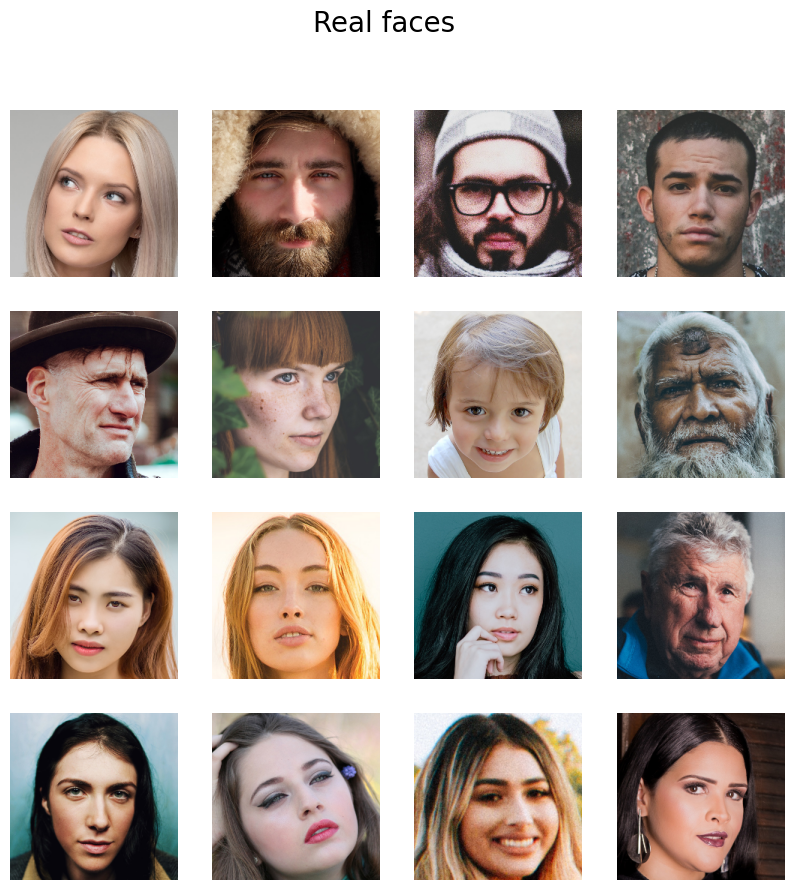

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    img1_path = os.path.join(real, real_path[i])  # Construct correct path using os.path.join
    rimg = load_img(img1_path)
    if rimg is not None:  # Check if image loaded successfully
      plt.subplot(4, 4, i+1)
      plt.imshow(rimg, cmap='gray')
      plt.suptitle("Real faces",fontsize=20)
      plt.axis('off')

plt.show()

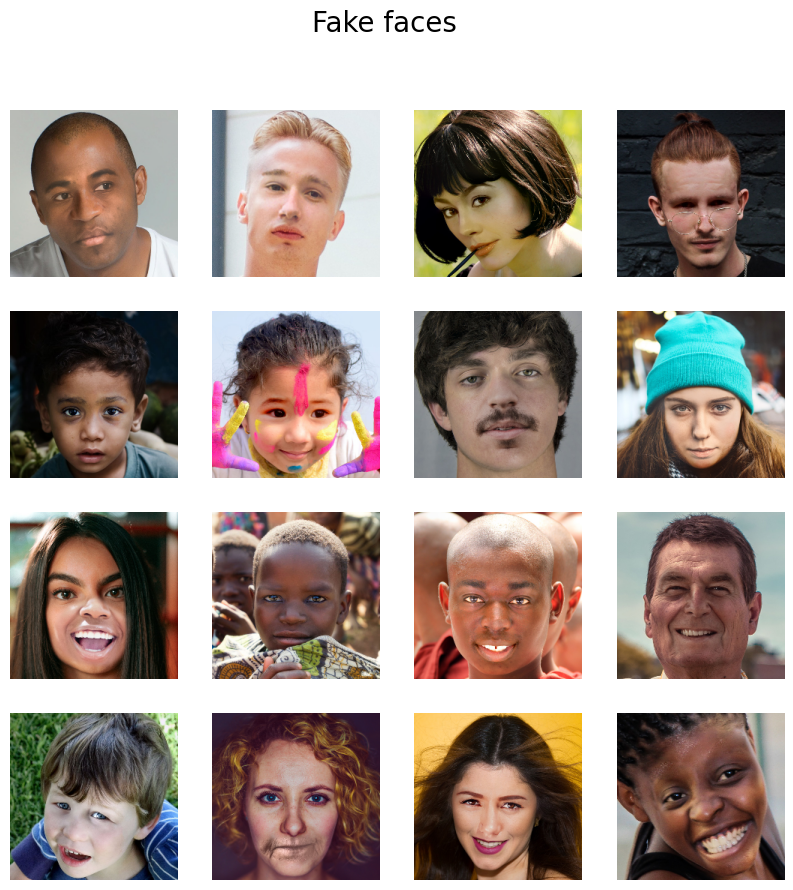

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    img2_path = os.path.join(fake, fake_path[i])  # Construct correct path using os.path.join
    fimg = load_img(img2_path)
    if fimg is not None:  # Check if image loaded successfully
      plt.subplot(4, 4, i+1)
      plt.imshow(fimg, cmap='gray')
      plt.suptitle("Fake faces",fontsize=20)
      plt.axis('off')

plt.show()

In [ ]:
dataset_path = "/content/image-classification-real-vs-fake"
data_with_augmentation = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.3)

# Create training dataset
train = data_with_augmentation.flow_from_directory(
    dataset_path,
    class_mode="binary",
    target_size=(96, 96),
    batch_size=32,
    subset="training")

# Create validation dataset
validate = data_with_augmentation.flow_from_directory(
    dataset_path,
    class_mode="binary",
    target_size=(96, 96),
    batch_size=32,
    subset="validation")

train.class_indices

Found 1429 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


{'.git': 0, 'fake': 1, 'real': 2}

In [ ]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    Dense(32, activation = "relu"),
                    Dropout(0.3),
                    Dense(1, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()
Model: "sequential"


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
hist = model.fit_generator(train, epochs=20, callbacks=[lr_callbacks], validation_data=validate)


<ipython-input-25-1d37553355b5>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train, epochs=20, callbacks=[lr_callbacks], validation_data=validate)


Epoch 1/20
45/45 [==============================] - 25s 545ms/step - loss: -16002.0449 - accuracy: 0.4703 - val_loss: -18051.1445 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - 25s 549ms/step - loss: -31239.5859 - accuracy: 0.4703 - val_loss: -39320.8047 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - 25s 551ms/step - loss: -68203.4922 - accuracy: 0.4703 - val_loss: -99146.0156 - val_accuracy: 0.4706 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - 25s 553ms/step - loss: -109012.7500 - accuracy: 0.4703 - val_loss: -96752.0078 - val_accuracy: 0.4706 - lr: 1.0000e-04
Epoch 5/20
45/45 [==============================] - 25s 546ms/step - loss: -118793.5156 - accuracy: 0.4703 - val_loss: -99497.4609 - val_accuracy: 0.4706 - lr: 1.0000e-04
Epoch 6/20
45/45 [==============================] - 25s 563ms/step - loss: -126952.8438 - accuracy: 0.4703 - val_loss: -105177.4609 - val_accuracy: 0.4706 - lr:

In [ ]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])


NameError: name 'hist' is not defined